In [1]:
using LinearAlgebra
using Random
using Statistics
using Plots
using CSV
using DataFrames
using ProgressMeter
using StatsBase
using LaTeXStrings

# Heart Disease predictor with an artificial neural network built from zero

###### By Servando Daniel López Reyes (18/06/2021)


The data was obtained from [kaggle.com](https://www.kaggle.com/ronitf/heart-disease-uci)

##### Context

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. 
In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
The goal field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

In [2]:
data = CSV.read("heart.csv", DataFrame)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64
1,63,1,3,145,233,1,0,150,0,2.3,0
2,37,1,2,130,250,0,1,187,0,3.5,0
3,41,0,1,130,204,0,0,172,0,1.4,2
4,56,1,1,120,236,0,1,178,0,0.8,2
5,57,0,0,120,354,0,1,163,1,0.6,2
6,57,1,0,140,192,0,1,148,0,0.4,1
7,56,0,1,140,294,0,0,153,0,1.3,1
8,44,1,1,120,263,0,1,173,0,0.0,2
9,52,1,2,172,199,1,1,162,0,0.5,2


Let's do a normalization of the data in order to work with smaller values

In [3]:
df = DataFrame([data[:, i]/maximum(data[:, i]) for i in 1:14]);

### Neural Network Construction

As the first step we define de **activation functión** for the neurons of the network and 
    the **cost function** that further we'll try to minimize with the **gradient descent algorithm**

In [4]:
#Sigmoid function
σ(x) = 1 / (1 + ℯ^(-x))

#Sigmoid's derivative
dσ(x) = x * (1 - x)

#Cost function
C(Yp, Yr) = -(Yr' * map(log, Yp)' + (ones(length(Yr)) - Yr)' * map(log, ones(length(Yp))' - Yp)')

C (generic function with 1 method)

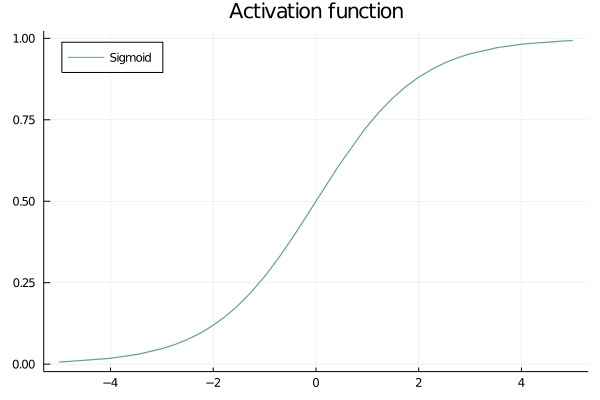

In [5]:
plot([σ], -5, 5, title="Activation function", lw=1.2,
    color="cadetblue", label="Sigmoid", legend=:topleft)

Now, we create a function called `neural_layer`, it receive as parameters the number of neurons of the layer (`n_neur`) and the number of conections with the next layer (`n_conn`), and returns the **matrix** with the random initial values of a single layer and a vector with the **bias** values

In [6]:
function neural_layer(n_neur, n_conn)
    
    b = randn(n_neur, 1)
    W = randn(n_neur, n_conn) 
    
    return [W, b]
end

neural_layer (generic function with 1 method)

As the next step we create the functión `create_nn` that build the **neural_network**, 
it receive as parameter a vector that contains the number of neurons of each layer. 
The function return the set of matrices and bias vectors that conform the network.

In [7]:
function create_nn(structure)
    
    nn = []
    
    for i in 1 : length(structure) - 1
        push!(nn, neural_layer(structure[i + 1], structure[i]))
    end
    
    return nn
end

create_nn (generic function with 1 method)

Then, we make a function that will do the **forward propagation** of the inputs through 
the layers of the NN. The function receive the NN that we built before and the 
input $X$. We need a function that do the **backpropagation** as well.

In [8]:
function forwardprop(nn, X)
    
    out = []
    push!(out, (nothing, X'))
    
    for i in 1:length(nn)
        Z = nn[i][1] * out[end][2] .+ nn[i][2]
        a = map(σ, Z)
        push!(out, (Z, a))
    end
    
    return out
end


function backprop(nn, X, Y)
    
    out = forwardprop(nn, X)
    δ = []
        
    for l in reverse(1:length(nn)) # We start from the last layer
            
        Z, a = out[l + 1] 

        if l == length(nn)
                
            #cumpute δᴸ
            δᴸ = a - Y'  #C_(a, Y') * map(σ_, a)
            insert!(δ, 1, δᴸ)
                
        else
            #compute δˡ
            δˡ = (nn[l + 1][1]' * δ[1]) .* map(dσ, a)
            insert!(δ, 1, δˡ)
            
        end
    end
    return δ
end

backprop (generic function with 1 method)

Create the `gradient_descent` function that will help us to optimize the 
**Cost function** and find the adequate parameters for the model.

In [9]:
function gradient_descent(nn, X, Y, α)
    
    out = forwardprop(nn, X)
    δ = backprop(nn, X, Y)
    δᵦ = copy(δ)
    
    for i in 1:length(δᵦ)
        δᵦ[i] = [mean(δᵦ[i][j,:]) for j in 1:size(δ[i])[1]]
    end

    for l in reverse(1:length(nn))
        Z, a = out[l]

        nn[l][2] -= α * δᵦ[l]
        nn[l][1] -= α * δ[l] * a'
    end
    
    return nn
end

gradient_descent (generic function with 1 method)

Finally, we construct the function `train` that, as the name say, it will 
    train the model with the training set that we'll define in the next cells.

In [10]:
function train(nn, X, Y, α, n_iter)
    
    m, n = size(X)
    cost = []
    
    @showprogress for i in 1:n_iter

        nn = gradient_descent(nn, X, Y, α)

        if i == 1 || i % (n_iter/50) == 0
            append!(cost, C(forwardprop(nn, X)[end][2], Y))
        end
    end
        
    return nn, cost
end

train (generic function with 1 method)

### Let's try out our Neural Network

The first step to train our model is split the dataset into **train set** and **test set**.

We define some parameters and variables:
- `train_set_size` Sample size (percentage of the dataset) to train the model
- `indexes` Random indexes that we'll take from the data set to train the model
- `X_train` Set to train the model (is a matrix). Because we have just 13 
characteristics (columns) and 303 instances (rows) in our dataset, the size of the matrix will be 
$(303\cdot train\_set\_test\times 13)$
- `y_test` Targets of the training set (is a vector)

In [12]:
train_set_size = 0.7
indexes = sample(1:size(df)[1], Int64(round(size(df)[1]*0.7)), replace = false);
X_train = Matrix(df[indexes, 1:13]);
y_train = Array(df[indexes, 14]);
X_test = Matrix(df[filter(x -> !(x in indexes), 1:size(df)[1]), 1:13]);
y_test = Array(df[filter(x -> !(x in indexes), 1:size(df)[1]), 14]);

##### Starting the traing phase...

In [14]:
p = size(X_train)[2]; #size of the inputs
structure = [p 4 1]; # Structure of the nn
nn = create_nn(structure); # Build the nn
α = 0.03 #Gradient descent parameter (nn learning ratio)
n_iter = 1000 #Number of iterations to train the nn

1000

In [15]:
nn_train, cost = train(nn, X_train, y_train, α, n_iter); #training the nn

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


The next graph shows the evolution of the cost function through the iterations, remind we was trying to minimize it. The lower the reached value, the better fit of the trainig set. We must be careful to don't overfit the model.

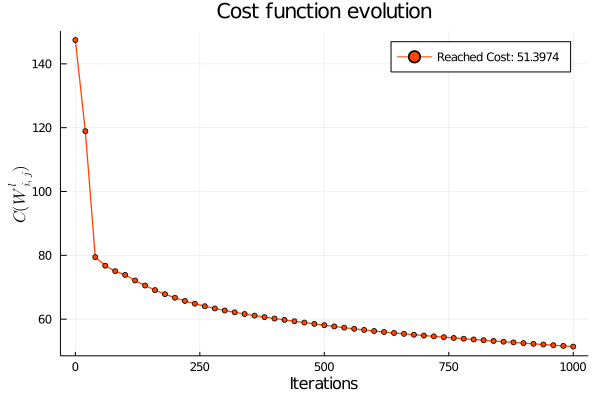

In [16]:
lowcost = round(cost[end], digits=4)

plot(0:n_iter÷50:length(cost)*(n_iter÷50) - 1, cost,
    markershape = :circle, markersize=3,
    color="orangered", lw=1.3,
    title="Cost function evolution",  
    xlabel="Iterations",
    ylabel=L"C(W^l_{i,j})",
    label="Reached Cost: $lowcost")

### Let´s test our model

Once we have a model that appear to work well, we proceed to test it using the **test set** we created before.

`out` is the vector that the neural network predict to be the targets of the **train set**. We will compare it with the actual targets vector, **y_train**, and then we will able to compute the precision of the neural netowork for the **training set**.

`preds` is the vector that the neural network predict to be the targets of the **test set**. We will compare it with the actual targets vector, **y_test**, and then we will able to compute the precision of the neural netowork for the **test set**.

In [17]:
out = round.(forwardprop(nn, X_train)[end][2])
train_precision = round(100sum([if (y_train[i] == out[i]) 1 else 
				0 end for i in 1:length(y_train)]) / length(y_train), digits=2)

88.68

In [18]:
preds = round.(forwardprop(nn, X_test)[end][2])
test_precision = round(100sum([if (y_test[i] == preds[i]) 1 else 
				0 end for i in 1:length(y_test)]) / length(y_test), digits=2)

81.32

As you can see, we reached a precision of approximately $93.39\%$ for the traing set, we should think in overfitting, but our precision is pretty decent for the test set, it's about $81.32\%$